In [4]:

import pyodbc
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


## Connection

In [15]:

# Connection parameters
server = input('Your server name')
database = 'AdventureWorks2019'


In [6]:

#  connection using Windows Authentication
conn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';Trusted_Connection=yes;')

# Creating a cursor
cursor = conn.cursor()

# query
cursor.execute("SELECT * FROM HL_Mountainframe")

# Fetch data
rows = cursor.fetchall()

#  data to  DataFrame
data = pd.DataFrame([tuple(row) for row in rows], columns=[column[0] for column in cursor.description])





In [7]:

        

# Create a tree structure using networkx
G = nx.DiGraph()

# Add nodes and edges
for _, row in data.iterrows():
    G.add_node(row['ProductID'], label=row['ProductName'])
    G.add_node(row['ComponentID'], label=row['ComponentName'])
    G.add_edge(row['ProductID'], row['ComponentID'], qty=row['PerAssemblyQty'])


In [8]:
def hierarchy_pos(G, root=None):
    pos = {}
    level_widths = {0: 1.0}
    y_offset = 1.0
    
    def assign_pos(node, x, y, level):
        pos[node] = (x, y)
        children = list(G.neighbors(node))
        
        if not children:
            return
        
        child_y = y - y_offset
        
        if level + 1 not in level_widths:
            level_widths[level + 1] = len(children)
        
        child_x_offset = level_widths[level + 1] * y_offset / 2
        
        for i, child in enumerate(children):
            child_x = x - child_x_offset + i * y_offset
            assign_pos(child, child_x, child_y, level + 1)
    
    assign_pos(root, 0.5, 1.0, 0)
    
    # Adjust positions to add gaps
    for node in pos:
        if G.nodes[node]['label'] == 'ComponentNameX':  
            pos[node] = (pos[node][0] + 0.1, pos[node][1])
        elif G.nodes[node]['label'] == 'ComponentNameY': 
            pos[node] = (pos[node][0] - 0.1, pos[node][1])
    
    return pos

In [13]:
# Find the root node (BOMLevel = 0)
root = data.loc[data['BOMLevel'] == 0, 'ProductID'].values[0]

# Get hierarchical positions for the nodes
pos = hierarchy_pos(G, root)

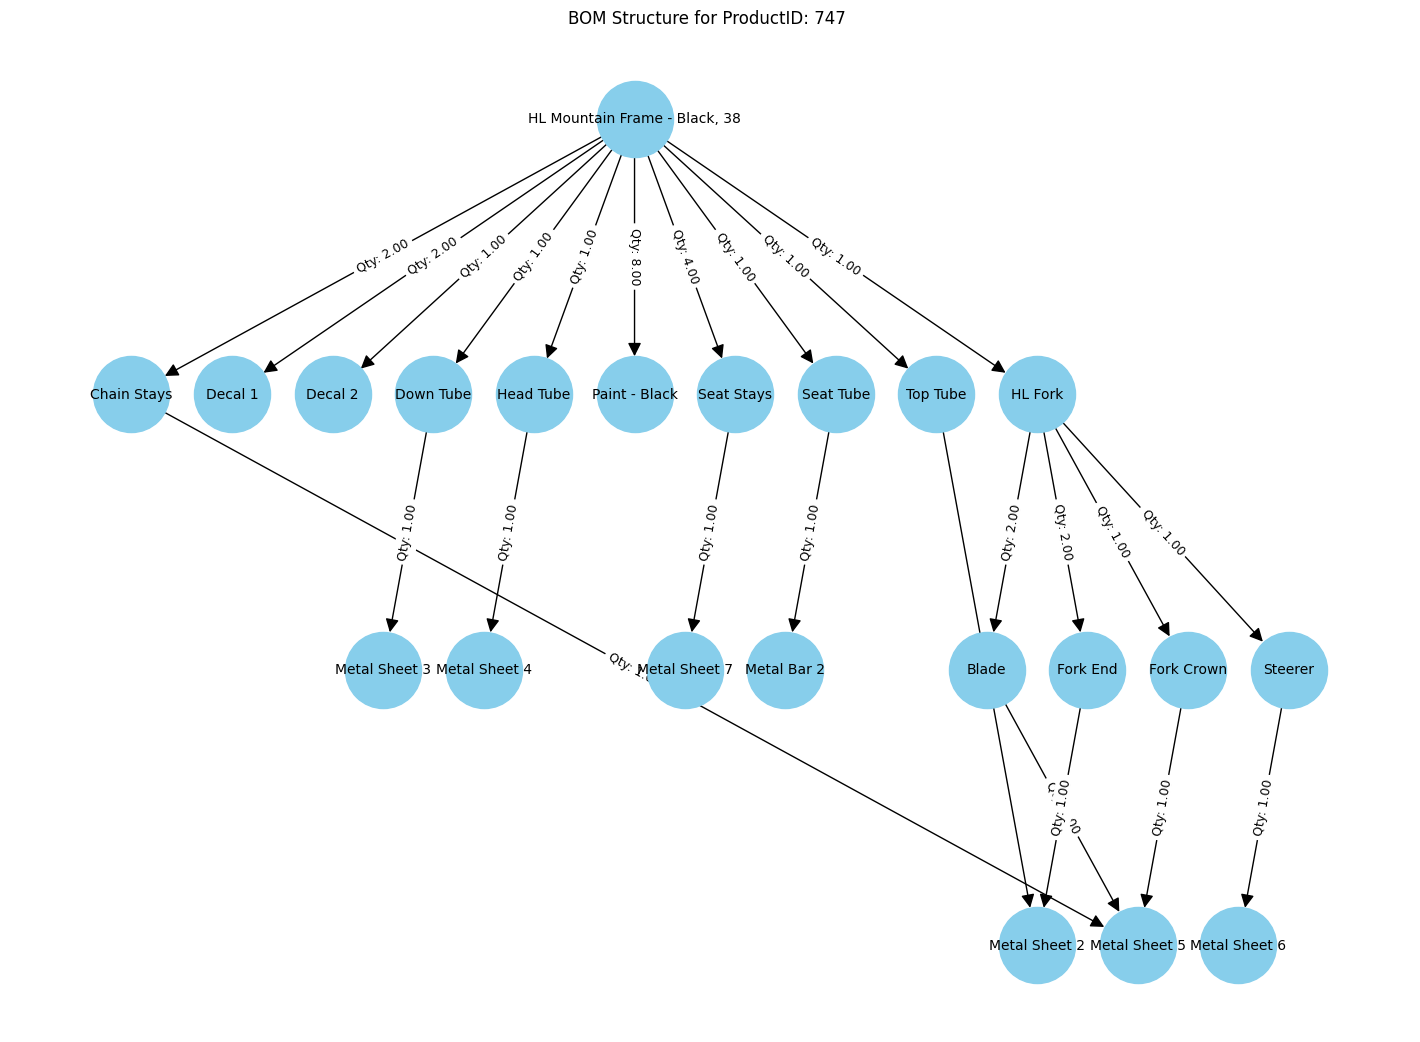

In [16]:

# Visualize the tree using matplotlib
plt.figure(figsize=(14, 10))  

# Draw the nodes with labels
nx.draw(G, pos, with_labels=False, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', arrowsize=20)

# Custom labels
labels = {node: G.nodes[node]['label'] for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)

# Draw edge labels (quantities)
edge_labels = {(u, v): f"Qty: {d['qty']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title(f'BOM Structure for ProductID: {root} ')
plt.show()
